In [1]:
#libraries
import numpy as np
import scipy.io
from scipy.io import loadmat
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
import matplotlib.colors
import time
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs
import torch
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [2]:
#reading data
df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('validation.csv')
df_test = pd.read_csv('test.csv')


In [3]:
print(df_train.head())

        f_1       f_2       f_3       f_4       f_5       f_6       f_7  \
0  0.390765  0.327932  0.502661  0.355642  0.471694  0.608545  0.452121   
1  0.457410  0.284467  0.484667  0.291260  0.451058  0.529749  0.526944   
2  0.403992  0.391960  0.474270  0.292279  0.391397  0.581557  0.440861   
3  0.518005  0.356605  0.512641  0.381103  0.394591  0.539064  0.632820   
4  0.506994  0.262952  0.533431  0.434244  0.611329  0.461541  0.486014   

        f_8       f_9      f_10  ...     f_292     f_293     f_294     f_295  \
0  0.591982  0.314631  0.228526  ...  0.430418  0.608150  0.633263  0.560759   
1  0.638828  0.330356  0.330626  ...  0.549414  0.595808  0.554878  0.479070   
2  0.656270  0.295054  0.349012  ...  0.485394  0.664941  0.536060  0.522882   
3  0.542462  0.307444  0.464495  ...  0.535646  0.540510  0.466792  0.439813   
4  0.410684  0.422045  0.399079  ...  0.242589  0.586996  0.582078  0.607442   

      f_296     f_297     f_298     f_299     f_300        genre  
0

# a) Statistics

Training Dataset

No. of classes  : 6 

             instances
genre                 
action            1312
comedy            3896
documentary       4861
drama             5483
horror            2104
thriller          1568


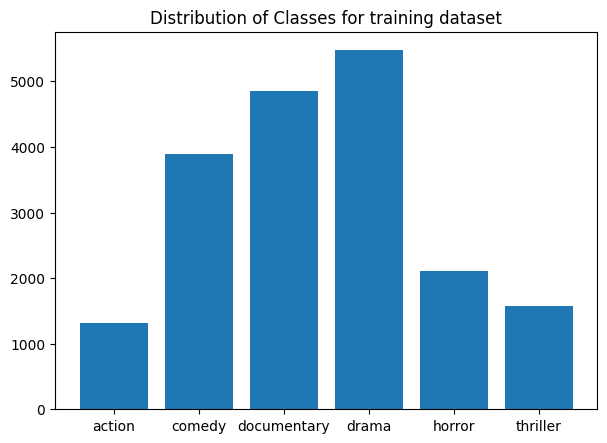

In [69]:
classes = df_train[['genre', 'f_300']].groupby('genre').count().round(2)

print("Training Dataset\n")

# counting unique values
n = len(classes)
print("No. of classes  :", n, "\n")

classes = classes.rename(columns={'f_300': 'instances'})
print(classes)
#f_300 can be taken as count of each class

fig, axes = plt.subplots(figsize=(7,5), dpi=100)
plt.bar(classes.index, height=classes.instances)
plt.title('Distribution of Classes for training dataset');

Validation Dataset

No. of classes  : 6 

             instances
genre                 
action             657
comedy            2241
documentary       2716
drama             3012
horror            1102
thriller           795


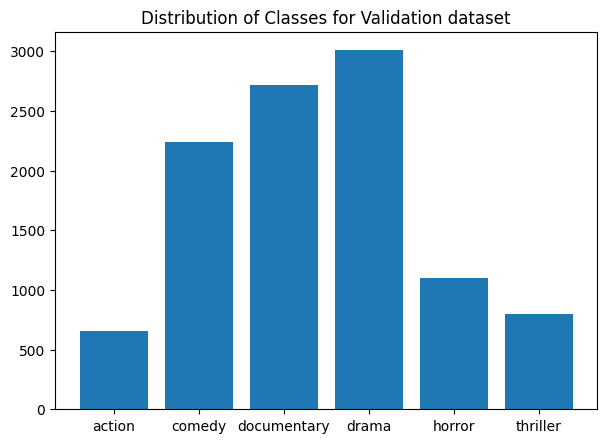

In [70]:
classes = df_val[['genre', 'f_300']].groupby('genre').count().round(2)

print("Validation Dataset\n")

# counting unique values
n = len(classes)
print("No. of classes  :", n, "\n")

classes = classes.rename(columns={'f_300': 'instances'})
print(classes)
#f_300 can be taken as count of each class

fig, axes = plt.subplots(figsize=(7,5), dpi=100)
plt.bar(classes.index, height=classes.instances)
plt.title('Distribution of Classes for Validation dataset');

Testing Dataset

No. of classes  : 6 

             instances
genre                 
action             657
comedy            2241
documentary       2716
drama             3012
horror            1102
thriller           795


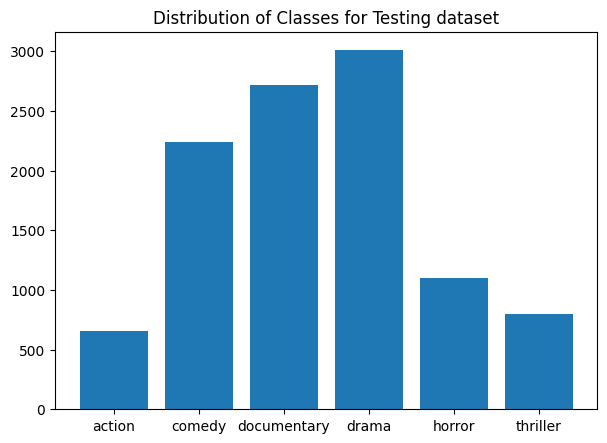

In [72]:
classes = df_test[['genre', 'f_300']].groupby('genre').count().round(2)

print("Testing Dataset\n")

# counting unique values
n = len(classes)
print("No. of classes  :", n, "\n")

classes = classes.rename(columns={'f_300': 'instances'})
print(classes)
#f_300 can be taken as count of each class

fig, axes = plt.subplots(figsize=(7,5), dpi=100)
plt.bar(classes.index, height=classes.instances)
plt.title('Distribution of Classes for Testing dataset');

In [6]:
# encoding genre names to numbers like onehotencoder
class_map = {e:i for i,e in enumerate(sorted(df_train['genre'].unique()))}


In [7]:
print(class_map)

{'action': 0, 'comedy': 1, 'documentary': 2, 'drama': 3, 'horror': 4, 'thriller': 5}


In [8]:
#Adding new column with numerical labels instead of genre 
df_train['classid'] = df_train['genre'].map(class_map)
df_val['classid'] = df_val['genre'].map(class_map)
df_test['classid'] = df_test['genre'].map(class_map)

In [9]:
print(df_train.head())

        f_1       f_2       f_3       f_4       f_5       f_6       f_7  \
0  0.390765  0.327932  0.502661  0.355642  0.471694  0.608545  0.452121   
1  0.457410  0.284467  0.484667  0.291260  0.451058  0.529749  0.526944   
2  0.403992  0.391960  0.474270  0.292279  0.391397  0.581557  0.440861   
3  0.518005  0.356605  0.512641  0.381103  0.394591  0.539064  0.632820   
4  0.506994  0.262952  0.533431  0.434244  0.611329  0.461541  0.486014   

        f_8       f_9      f_10  ...     f_293     f_294     f_295     f_296  \
0  0.591982  0.314631  0.228526  ...  0.608150  0.633263  0.560759  0.560722   
1  0.638828  0.330356  0.330626  ...  0.595808  0.554878  0.479070  0.573839   
2  0.656270  0.295054  0.349012  ...  0.664941  0.536060  0.522882  0.550427   
3  0.542462  0.307444  0.464495  ...  0.540510  0.466792  0.439813  0.493765   
4  0.410684  0.422045  0.399079  ...  0.586996  0.582078  0.607442  0.358049   

      f_297     f_298     f_299     f_300        genre  classid  
0 

In [10]:
df_train.shape

(19224, 302)

In [11]:
# x_train = df_train.drop('genre', axis=1)
# X_train= torch.tensor(x_train.to_numpy(), dtype=torch.float32)
# y_train = df_train['classid']
# Y_train= torch.tensor(y_train.to_numpy(), dtype=torch.float32)
# print(x_train)

# b) implementation of feedfordward NN (dynamic with n layers)

In [12]:
batch_size = 50
n_iters = 1000
num_epochs = 61


class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        layer_list = [self.fc1]
        layer_list.append(nn.Sigmoid())
            
        for e in range(n_layers-1):
            layer_list.append(nn.Linear(hidden_dim, hidden_dim) )
            layer_list.append(nn.Sigmoid())
        # Non-linearity
        self.layer = nn.Sequential(*layer_list)

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):

        # Non-linearity  # NON-LINEAR
        out = self.layer(x)

        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        return out



In [13]:
list_of_classes = [0,1,2,3,4,5]
model_accuracy = []
model_loss = []

# c) Model 1: one hidden layer with 64 neurons

In [14]:
input_dim = 300
hidden_dim = 64
output_dim = 6

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim, 1)

In [15]:
#using cross entropy loss
criterion = nn.CrossEntropyLoss()

In [16]:
learning_rate = 0.1
#SGD as optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [17]:
#print(FeedforwardNeuralNetModel.parameters())

params = list(model.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

4
torch.Size([64, 300])


In [18]:
print(model)

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=300, out_features=64, bias=True)
  (layer): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)


In [19]:
BATCH_SIZE = 50
iter = 0

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    correct_class = [0 for c in list_of_classes]
    total_class= [0 for c in list_of_classes]
    correct_class_val = [0 for c in list_of_classes]
    total_class_val = [0 for c in list_of_classes]
    ctrain_acc = [0 for c in list_of_classes]
    cval_acc = [0 for c in list_of_classes]
    
    #TRAINING
    for i in range(0, df_train.shape[0], BATCH_SIZE):

        #creating tensors from df_train where X is feature set and Y is label
        X = df_train.iloc[i:i+BATCH_SIZE,0:300]
        X = torch.tensor(X.values, dtype=torch.float32)
        Y = df_train.iloc[i:i+BATCH_SIZE]['classid']
        Y = torch.tensor(Y.values)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(X)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, Y)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += Y.size(0)

        # Total correct predictions
        correct += (predicted == Y).sum()

        train_acc = 100 * correct / total
        
        train_loss = loss
        ftrain_acc = train_acc
        

        for c in list_of_classes:
            correct_class[c] += ((predicted == Y) * (Y == c)).float().sum()
            total_class[c] += ((Y == c).sum())
            ctrain_acc[c] = (correct_class[c].item()) / (total_class[c])

        
    if ((epoch%20)==0):    
        print(f'\t [Epoch] : {epoch} | [Train Loss] : {loss:.3f} | [Train Acc] : {train_acc}%\n')

    
   #VALIDATION 
    model.eval() 
    correct = 0
    total = 0
    for i in range(0, df_val.shape[0], BATCH_SIZE):

        X = df_val.iloc[i:i+BATCH_SIZE,0:300]
        X = torch.tensor(X.values, dtype=torch.float32)
        Y = df_val.iloc[i:i+BATCH_SIZE]['classid']
        Y = torch.tensor(Y.values)

        #dont effect weights

        # Forward pass to get output/logits
        outputs = model(X)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, Y)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += Y.size(0)

        # Total correct predictions
        correct += (predicted == Y).sum()

        val_acc = 100 * correct / total
        
        val_loss = loss
        fval_acc = val_acc

        
        for c in list_of_classes:
            correct_class_val[c] += ((predicted == Y) * (Y == c)).float().sum()
            total_class_val[c] += ((Y == c).sum())
            cval_acc[c] = (correct_class_val[c].item()) / (total_class_val[c])

    if ((epoch%20)==0):
        print(f'\t [Epoch] : {epoch} | [Validation Loss] : {loss:.3f} | [Validation Acc] : {val_acc}%\n')
        
model_accuracy.append(train_acc)
model_loss.append(train_loss)        
model_accuracy.append(val_acc)
model_loss.append(val_loss)   

	 [Epoch] : 0 | [Train Loss] : 1.578 | [Train Acc] : 28.55805206298828%

	 [Epoch] : 0 | [Validation Loss] : 1.768 | [Validation Acc] : 28.623016357421875%

	 [Epoch] : 20 | [Train Loss] : 1.297 | [Train Acc] : 59.425716400146484%

	 [Epoch] : 20 | [Validation Loss] : 1.342 | [Validation Acc] : 59.18464279174805%

	 [Epoch] : 40 | [Train Loss] : 1.232 | [Train Acc] : 63.43632888793945%

	 [Epoch] : 40 | [Validation Loss] : 1.322 | [Validation Acc] : 62.77677536010742%

	 [Epoch] : 60 | [Train Loss] : 1.195 | [Train Acc] : 65.16333770751953%

	 [Epoch] : 60 | [Validation Loss] : 1.305 | [Validation Acc] : 63.63204574584961%



In [20]:
print(f'\t [Train Loss] : {train_loss:.3f} | [Train Acc] : {ftrain_acc}%\n')
print(f'\t [Val Loss] : {val_loss:.3f} | [Val Acc] : {fval_acc}%\n')

print("Accuracy by class with class map as follows", class_map, "\n")

for i in range(len(ctrain_acc)):
    print("Training Accuracy: ", "{:.3%}".format(ctrain_acc[i]), "and Validation Accuracy: ", "{:.3%}".format(cval_acc[i]), "for class:", i,"\n")



	 [Train Loss] : 1.195 | [Train Acc] : 65.16333770751953%

	 [Val Loss] : 1.305 | [Val Acc] : 63.63204574584961%

Accuracy by class with class map as follows {'action': 0, 'comedy': 1, 'documentary': 2, 'drama': 3, 'horror': 4, 'thriller': 5} 

Training Accuracy:  48.476% and Validation Accuracy:  25.419% for class: 0 

Training Accuracy:  60.857% and Validation Accuracy:  70.906% for class: 1 

Training Accuracy:  82.864% and Validation Accuracy:  78.866% for class: 2 

Training Accuracy:  67.627% and Validation Accuracy:  61.687% for class: 3 

Training Accuracy:  69.249% and Validation Accuracy:  84.936% for class: 4 

Training Accuracy:  20.855% and Validation Accuracy:  0.503% for class: 5 



In [21]:
#TESTING
model.eval() 
correct = 0
total = 0
correct_class = [0 for c in list_of_classes]
total_class= [0 for c in list_of_classes]
ctest_acc = [0 for c in list_of_classes]

for i in range(0, df_test.shape[0], BATCH_SIZE):

    X = df_test.iloc[i:i+BATCH_SIZE,0:300]
    X = torch.tensor(X.values, dtype=torch.float32)
    Y = df_test.iloc[i:i+BATCH_SIZE]['classid']
    Y = torch.tensor(Y.values)

    #dont effect weights

    # Forward pass to get output/logits
    outputs = model(X)

    # Calculate Loss: softmax --> cross entropy loss
    loss = criterion(outputs, Y)
        
    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)

    # Total number of labels
    total += Y.size(0)

    # Total correct predictions
    correct += (predicted == Y).sum()

    test_acc = 100 * correct / total
    
    test_loss = loss
    ftest_acc = test_acc

    for c in list_of_classes:
        correct_class[c] += ((predicted == Y) * (Y == c)).float().sum()
        total_class[c] += ((Y == c).sum())
        ctest_acc[c] = (correct_class[c].item()) / (total_class[c])
        
print(f'\t [Test Loss] : {loss:.3f} | [Test Acc] : {test_acc}%\n')

model_accuracy.append(test_acc)
model_loss.append(test_loss)    

print("Accuracy by class with class map as follows", class_map, "\n")

for i in range(len(ctrain_acc)):
    print("Test Accuracy: ", "{:.2%}".format(ctest_acc[i]), "for class:", i,"\n")

	 [Test Loss] : 0.855 | [Test Acc] : 63.36595916748047%

Accuracy by class with class map as follows {'action': 0, 'comedy': 1, 'documentary': 2, 'drama': 3, 'horror': 4, 'thriller': 5} 

Test Accuracy:  29.53% for class: 0 

Test Accuracy:  71.80% for class: 1 

Test Accuracy:  77.69% for class: 2 

Test Accuracy:  60.39% for class: 3 

Test Accuracy:  84.30% for class: 4 

Test Accuracy:  0.88% for class: 5 



In [22]:
#Final Loss and Accuracies

print("Model with one hidden layer of 64 neurons\n")
print(f'\t [Train Loss] : {train_loss:.3f} | [Train Acc] : {ftrain_acc}%\n')
print(f'\t [Val Loss] : {val_loss:.3f} | [Val Acc] : {fval_acc}%\n')
print(f'\t [Test Loss] : {test_loss:.3f} | [Test Acc] : {ftest_acc}%\n')

Model with one hidden layer of 64 neurons

	 [Train Loss] : 1.195 | [Train Acc] : 65.16333770751953%

	 [Val Loss] : 1.305 | [Val Acc] : 63.63204574584961%

	 [Test Loss] : 0.855 | [Test Acc] : 63.36595916748047%



# d) Model 2: two hidden layer with 64 neurons

In [23]:
input_dim = 300
hidden_dim = 64
output_dim = 6

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim, 2)

In [24]:
#using cross entropy loss
criterion = nn.CrossEntropyLoss()

In [25]:
learning_rate = 0.1
#SGD as optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [26]:
#print(FeedforwardNeuralNetModel.parameters())

params = list(model.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

6
torch.Size([64, 300])


In [27]:
print(model)

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=300, out_features=64, bias=True)
  (layer): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)


In [28]:
BATCH_SIZE = 50
iter = 0

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    correct_class = [0 for c in list_of_classes]
    total_class= [0 for c in list_of_classes]
    correct_class_val = [0 for c in list_of_classes]
    total_class_val = [0 for c in list_of_classes]
    ctrain_acc = [0 for c in list_of_classes]
    cval_acc = [0 for c in list_of_classes]
    
    #TRAINING
    for i in range(0, df_train.shape[0], BATCH_SIZE):

        #creating tensors from df_train where X is feature set and Y is label
        X = df_train.iloc[i:i+BATCH_SIZE,0:300]
        X = torch.tensor(X.values, dtype=torch.float32)
        Y = df_train.iloc[i:i+BATCH_SIZE]['classid']
        Y = torch.tensor(Y.values)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(X)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, Y)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += Y.size(0)

        # Total correct predictions
        correct += (predicted == Y).sum()

        train_acc = 100 * correct / total
        
        train_loss = loss
        ftrain_acc = train_acc
        

        for c in list_of_classes:
            correct_class[c] += ((predicted == Y) * (Y == c)).float().sum()
            total_class[c] += ((Y == c).sum())
            ctrain_acc[c] = (correct_class[c].item()) / (total_class[c])

        
    if ((epoch%20)==0):    
        print(f'\t [Epoch] : {epoch} | [Train Loss] : {loss:.3f} | [Train Acc] : {train_acc}%\n')

    
   #VALIDATION 
    model.eval() 
    correct = 0
    total = 0
    for i in range(0, df_val.shape[0], BATCH_SIZE):

        X = df_val.iloc[i:i+BATCH_SIZE,0:300]
        X = torch.tensor(X.values, dtype=torch.float32)
        Y = df_val.iloc[i:i+BATCH_SIZE]['classid']
        Y = torch.tensor(Y.values)

        #dont effect weights

        # Forward pass to get output/logits
        outputs = model(X)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, Y)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += Y.size(0)

        # Total correct predictions
        correct += (predicted == Y).sum()

        val_acc = 100 * correct / total
        
        val_loss = loss
        fval_acc = val_acc

        
        for c in list_of_classes:
            correct_class_val[c] += ((predicted == Y) * (Y == c)).float().sum()
            total_class_val[c] += ((Y == c).sum())
            cval_acc[c] = (correct_class_val[c].item()) / (total_class_val[c])

    if ((epoch%20)==0):
        print(f'\t [Epoch] : {epoch} | [Validation Loss] : {loss:.3f} | [Validation Acc] : {val_acc}%\n')
        
model_accuracy.append(train_acc)
model_loss.append(train_loss)        
model_accuracy.append(val_acc)
model_loss.append(val_loss)   

	 [Epoch] : 0 | [Train Loss] : 1.582 | [Train Acc] : 27.814189910888672%

	 [Epoch] : 0 | [Validation Loss] : 1.775 | [Validation Acc] : 28.623016357421875%

	 [Epoch] : 20 | [Train Loss] : 1.448 | [Train Acc] : 43.13878631591797%

	 [Epoch] : 20 | [Validation Loss] : 1.499 | [Validation Acc] : 43.599735260009766%

	 [Epoch] : 40 | [Train Loss] : 1.319 | [Train Acc] : 57.043277740478516%

	 [Epoch] : 40 | [Validation Loss] : 1.377 | [Validation Acc] : 57.81621170043945%

	 [Epoch] : 60 | [Train Loss] : 1.244 | [Train Acc] : 60.72617721557617%

	 [Epoch] : 60 | [Validation Loss] : 1.305 | [Validation Acc] : 60.1634521484375%



In [29]:
print(f'\t [Train Loss] : {train_loss:.3f} | [Train Acc] : {ftrain_acc}%\n')
print(f'\t [Val Loss] : {val_loss:.3f} | [Val Acc] : {fval_acc}%\n')

print("Accuracy by class with class map as follows", class_map, "\n")

for i in range(len(ctrain_acc)):
    print("Training Accuracy: ", "{:.3%}".format(ctrain_acc[i]), "and Validation Accuracy: ", "{:.3%}".format(cval_acc[i]), "for class:", i,"\n")



	 [Train Loss] : 1.244 | [Train Acc] : 60.72617721557617%

	 [Val Loss] : 1.305 | [Val Acc] : 60.1634521484375%

Accuracy by class with class map as follows {'action': 0, 'comedy': 1, 'documentary': 2, 'drama': 3, 'horror': 4, 'thriller': 5} 

Training Accuracy:  7.470% and Validation Accuracy:  1.979% for class: 0 

Training Accuracy:  59.292% and Validation Accuracy:  81.214% for class: 1 

Training Accuracy:  82.699% and Validation Accuracy:  79.786% for class: 2 

Training Accuracy:  67.427% and Validation Accuracy:  52.025% for class: 3 

Training Accuracy:  68.726% and Validation Accuracy:  69.147% for class: 4 

Training Accuracy:  6.569% and Validation Accuracy:  0.252% for class: 5 



In [30]:
#TESTING
model.eval() 
correct = 0
total = 0
correct_class = [0 for c in list_of_classes]
total_class= [0 for c in list_of_classes]
ctest_acc = [0 for c in list_of_classes]

for i in range(0, df_test.shape[0], BATCH_SIZE):

    X = df_test.iloc[i:i+BATCH_SIZE,0:300]
    X = torch.tensor(X.values, dtype=torch.float32)
    Y = df_test.iloc[i:i+BATCH_SIZE]['classid']
    Y = torch.tensor(Y.values)

    #dont effect weights

    # Forward pass to get output/logits
    outputs = model(X)

    # Calculate Loss: softmax --> cross entropy loss
    loss = criterion(outputs, Y)
        
    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)

    # Total number of labels
    total += Y.size(0)

    # Total correct predictions
    correct += (predicted == Y).sum()

    test_acc = 100 * correct / total
    
    test_loss = loss
    ftest_acc = test_acc

    for c in list_of_classes:
        correct_class[c] += ((predicted == Y) * (Y == c)).float().sum()
        total_class[c] += ((Y == c).sum())
        ctest_acc[c] = (correct_class[c].item()) / (total_class[c])
        
print(f'\t [Test Loss] : {loss:.3f} | [Test Acc] : {test_acc}%\n')

model_accuracy.append(test_acc)
model_loss.append(test_loss)    

print("Accuracy by class with class map as follows", class_map, "\n")

for i in range(len(ctrain_acc)):
    print("Test Accuracy: ", "{:.2%}".format(ctest_acc[i]), "for class:", i,"\n")

	 [Test Loss] : 0.800 | [Test Acc] : 59.57426452636719%

Accuracy by class with class map as follows {'action': 0, 'comedy': 1, 'documentary': 2, 'drama': 3, 'horror': 4, 'thriller': 5} 

Test Accuracy:  3.65% for class: 0 

Test Accuracy:  81.21% for class: 1 

Test Accuracy:  78.72% for class: 2 

Test Accuracy:  52.19% for class: 3 

Test Accuracy:  64.70% for class: 4 

Test Accuracy:  0.25% for class: 5 



In [31]:
#Final Loss and Accuracies

print("Model with two hidden layers of 64 neurons\n")
print(f'\t [Train Loss] : {train_loss:.3f} | [Train Acc] : {ftrain_acc}%\n')
print(f'\t [Val Loss] : {val_loss:.3f} | [Val Acc] : {fval_acc}%\n')
print(f'\t [Test Loss] : {test_loss:.3f} | [Test Acc] : {ftest_acc}%\n')

Model with two hidden layers of 64 neurons

	 [Train Loss] : 1.244 | [Train Acc] : 60.72617721557617%

	 [Val Loss] : 1.305 | [Val Acc] : 60.1634521484375%

	 [Test Loss] : 0.800 | [Test Acc] : 59.57426452636719%



# e) model 3: one hidden layer 128 neurons 

In [32]:
input_dim = 300
hidden_dim = 128
output_dim = 6

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim, 1)

#using cross entropy loss
criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
#SGD as optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#print(FeedforwardNeuralNetModel.parameters())

params = list(model.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

print(model)

4
torch.Size([128, 300])
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (layer): Sequential(
    (0): Linear(in_features=300, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [33]:
BATCH_SIZE = 50
iter = 0

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    correct_class = [0 for c in list_of_classes]
    total_class= [0 for c in list_of_classes]
    correct_class_val = [0 for c in list_of_classes]
    total_class_val = [0 for c in list_of_classes]
    ctrain_acc = [0 for c in list_of_classes]
    cval_acc = [0 for c in list_of_classes]
    
    #TRAINING
    for i in range(0, df_train.shape[0], BATCH_SIZE):

        #creating tensors from df_train where X is feature set and Y is label
        X = df_train.iloc[i:i+BATCH_SIZE,0:300]
        X = torch.tensor(X.values, dtype=torch.float32)
        Y = df_train.iloc[i:i+BATCH_SIZE]['classid']
        Y = torch.tensor(Y.values)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(X)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, Y)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += Y.size(0)

        # Total correct predictions
        correct += (predicted == Y).sum()

        train_acc = 100 * correct / total
        
        train_loss = loss
        ftrain_acc = train_acc
        

        for c in list_of_classes:
            correct_class[c] += ((predicted == Y) * (Y == c)).float().sum()
            total_class[c] += ((Y == c).sum())
            ctrain_acc[c] = (correct_class[c].item()) / (total_class[c])

        
    if ((epoch%20)==0):    
        print(f'\t [Epoch] : {epoch} | [Train Loss] : {loss:.3f} | [Train Acc] : {train_acc}%\n')

    
   #VALIDATION 
    model.eval() 
    correct = 0
    total = 0
    for i in range(0, df_val.shape[0], BATCH_SIZE):

        X = df_val.iloc[i:i+BATCH_SIZE,0:300]
        X = torch.tensor(X.values, dtype=torch.float32)
        Y = df_val.iloc[i:i+BATCH_SIZE]['classid']
        Y = torch.tensor(Y.values)

        #dont effect weights

        # Forward pass to get output/logits
        outputs = model(X)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, Y)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += Y.size(0)

        # Total correct predictions
        correct += (predicted == Y).sum()

        val_acc = 100 * correct / total
        
        val_loss = loss
        fval_acc = val_acc

        
        for c in list_of_classes:
            correct_class_val[c] += ((predicted == Y) * (Y == c)).float().sum()
            total_class_val[c] += ((Y == c).sum())
            cval_acc[c] = (correct_class_val[c].item()) / (total_class_val[c])

    if ((epoch%20)==0):
        print(f'\t [Epoch] : {epoch} | [Validation Loss] : {loss:.3f} | [Validation Acc] : {val_acc}%\n')
        
model_accuracy.append(train_acc)
model_loss.append(train_loss)        
model_accuracy.append(val_acc)
model_loss.append(val_loss)   

	 [Epoch] : 0 | [Train Loss] : 1.579 | [Train Acc] : 27.678943634033203%

	 [Epoch] : 0 | [Validation Loss] : 1.763 | [Validation Acc] : 28.623016357421875%

	 [Epoch] : 20 | [Train Loss] : 1.298 | [Train Acc] : 58.900333404541016%

	 [Epoch] : 20 | [Validation Loss] : 1.364 | [Validation Acc] : 59.04209899902344%

	 [Epoch] : 40 | [Train Loss] : 1.243 | [Train Acc] : 63.28547668457031%

	 [Epoch] : 40 | [Validation Loss] : 1.331 | [Validation Acc] : 62.60572052001953%

	 [Epoch] : 60 | [Train Loss] : 1.208 | [Train Acc] : 65.16333770751953%

	 [Epoch] : 60 | [Validation Loss] : 1.312 | [Validation Acc] : 63.31844711303711%



In [34]:
print(f'\t [Train Loss] : {train_loss:.3f} | [Train Acc] : {ftrain_acc}%\n')
print(f'\t [Val Loss] : {val_loss:.3f} | [Val Acc] : {fval_acc}%\n')

print("Accuracy by class with class map as follows", class_map, "\n")

for i in range(len(ctrain_acc)):
    print("Training Accuracy: ", "{:.3%}".format(ctrain_acc[i]), "and Validation Accuracy: ", "{:.3%}".format(cval_acc[i]), "for class:", i,"\n")



	 [Train Loss] : 1.208 | [Train Acc] : 65.16333770751953%

	 [Val Loss] : 1.312 | [Val Acc] : 63.31844711303711%

Accuracy by class with class map as follows {'action': 0, 'comedy': 1, 'documentary': 2, 'drama': 3, 'horror': 4, 'thriller': 5} 

Training Accuracy:  48.018% and Validation Accuracy:  25.571% for class: 0 

Training Accuracy:  60.498% and Validation Accuracy:  72.646% for class: 1 

Training Accuracy:  82.637% and Validation Accuracy:  76.988% for class: 2 

Training Accuracy:  67.937% and Validation Accuracy:  61.255% for class: 3 

Training Accuracy:  69.106% and Validation Accuracy:  84.120% for class: 4 

Training Accuracy:  21.939% and Validation Accuracy:  0.503% for class: 5 



In [35]:
#TESTING
model.eval() 
correct = 0
total = 0
correct_class = [0 for c in list_of_classes]
total_class= [0 for c in list_of_classes]
ctest_acc = [0 for c in list_of_classes]

for i in range(0, df_test.shape[0], BATCH_SIZE):

    X = df_test.iloc[i:i+BATCH_SIZE,0:300]
    X = torch.tensor(X.values, dtype=torch.float32)
    Y = df_test.iloc[i:i+BATCH_SIZE]['classid']
    Y = torch.tensor(Y.values)

    #dont effect weights

    # Forward pass to get output/logits
    outputs = model(X)

    # Calculate Loss: softmax --> cross entropy loss
    loss = criterion(outputs, Y)
        
    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)

    # Total number of labels
    total += Y.size(0)

    # Total correct predictions
    correct += (predicted == Y).sum()

    test_acc = 100 * correct / total
    
    test_loss = loss
    ftest_acc = test_acc

    for c in list_of_classes:
        correct_class[c] += ((predicted == Y) * (Y == c)).float().sum()
        total_class[c] += ((Y == c).sum())
        ctest_acc[c] = (correct_class[c].item()) / (total_class[c])
        
print(f'\t [Test Loss] : {loss:.3f} | [Test Acc] : {test_acc}%\n')

model_accuracy.append(test_acc)
model_loss.append(test_loss)    

print("Accuracy by class with class map as follows", class_map, "\n")

for i in range(len(ctrain_acc)):
    print("Test Accuracy: ", "{:.2%}".format(ctest_acc[i]), "for class:", i,"\n")

	 [Test Loss] : 0.859 | [Test Acc] : 63.09037399291992%

Accuracy by class with class map as follows {'action': 0, 'comedy': 1, 'documentary': 2, 'drama': 3, 'horror': 4, 'thriller': 5} 

Test Accuracy:  29.53% for class: 0 

Test Accuracy:  73.85% for class: 1 

Test Accuracy:  75.77% for class: 2 

Test Accuracy:  60.46% for class: 3 

Test Accuracy:  82.03% for class: 4 

Test Accuracy:  0.88% for class: 5 



In [36]:
#Final Loss and Accuracies

print("Model with one hidden layers of 128 neurons\n")
print(f'\t [Train Loss] : {train_loss:.3f} | [Train Acc] : {ftrain_acc}%\n')
print(f'\t [Val Loss] : {val_loss:.3f} | [Val Acc] : {fval_acc}%\n')
print(f'\t [Test Loss] : {test_loss:.3f} | [Test Acc] : {ftest_acc}%\n')

Model with one hidden layers of 128 neurons

	 [Train Loss] : 1.208 | [Train Acc] : 65.16333770751953%

	 [Val Loss] : 1.312 | [Val Acc] : 63.31844711303711%

	 [Test Loss] : 0.859 | [Test Acc] : 63.09037399291992%



# f) model 4: two hidden layers 128 neurons 

In [37]:
input_dim = 300
hidden_dim = 128
output_dim = 6

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim, 2)

#using cross entropy loss
criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
#SGD as optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#print(FeedforwardNeuralNetModel.parameters())

params = list(model.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

print(model)

6
torch.Size([128, 300])
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (layer): Sequential(
    (0): Linear(in_features=300, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [38]:
BATCH_SIZE = 50
iter = 0

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    correct_class = [0 for c in list_of_classes]
    total_class= [0 for c in list_of_classes]
    correct_class_val = [0 for c in list_of_classes]
    total_class_val = [0 for c in list_of_classes]
    ctrain_acc = [0 for c in list_of_classes]
    cval_acc = [0 for c in list_of_classes]
    
    #TRAINING
    for i in range(0, df_train.shape[0], BATCH_SIZE):

        #creating tensors from df_train where X is feature set and Y is label
        X = df_train.iloc[i:i+BATCH_SIZE,0:300]
        X = torch.tensor(X.values, dtype=torch.float32)
        Y = df_train.iloc[i:i+BATCH_SIZE]['classid']
        Y = torch.tensor(Y.values)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(X)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, Y)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += Y.size(0)

        # Total correct predictions
        correct += (predicted == Y).sum()

        train_acc = 100 * correct / total
        
        train_loss = loss
        ftrain_acc = train_acc
        

        for c in list_of_classes:
            correct_class[c] += ((predicted == Y) * (Y == c)).float().sum()
            total_class[c] += ((Y == c).sum())
            ctrain_acc[c] = (correct_class[c].item()) / (total_class[c])

        
    if ((epoch%20)==0):    
        print(f'\t [Epoch] : {epoch} | [Train Loss] : {loss:.3f} | [Train Acc] : {train_acc}%\n')

    
   #VALIDATION 
    model.eval() 
    correct = 0
    total = 0
    for i in range(0, df_val.shape[0], BATCH_SIZE):

        X = df_val.iloc[i:i+BATCH_SIZE,0:300]
        X = torch.tensor(X.values, dtype=torch.float32)
        Y = df_val.iloc[i:i+BATCH_SIZE]['classid']
        Y = torch.tensor(Y.values)

        #dont effect weights

        # Forward pass to get output/logits
        outputs = model(X)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, Y)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += Y.size(0)

        # Total correct predictions
        correct += (predicted == Y).sum()

        val_acc = 100 * correct / total
        
        val_loss = loss
        fval_acc = val_acc

        
        for c in list_of_classes:
            correct_class_val[c] += ((predicted == Y) * (Y == c)).float().sum()
            total_class_val[c] += ((Y == c).sum())
            cval_acc[c] = (correct_class_val[c].item()) / (total_class_val[c])

    if ((epoch%20)==0):
        print(f'\t [Epoch] : {epoch} | [Validation Loss] : {loss:.3f} | [Validation Acc] : {val_acc}%\n')
        
model_accuracy.append(train_acc)
model_loss.append(train_loss)        
model_accuracy.append(val_acc)
model_loss.append(val_loss)   

	 [Epoch] : 0 | [Train Loss] : 1.585 | [Train Acc] : 26.680191040039062%

	 [Epoch] : 0 | [Validation Loss] : 1.768 | [Validation Acc] : 28.623016357421875%

	 [Epoch] : 20 | [Train Loss] : 1.461 | [Train Acc] : 42.07761001586914%

	 [Epoch] : 20 | [Validation Loss] : 1.507 | [Validation Acc] : 42.411861419677734%

	 [Epoch] : 40 | [Train Loss] : 1.323 | [Train Acc] : 56.16937255859375%

	 [Epoch] : 40 | [Validation Loss] : 1.394 | [Validation Acc] : 57.39807891845703%

	 [Epoch] : 60 | [Train Loss] : 1.246 | [Train Acc] : 60.01872634887695%

	 [Epoch] : 60 | [Validation Loss] : 1.326 | [Validation Acc] : 59.51724624633789%



In [39]:
print(f'\t [Train Loss] : {train_loss:.3f} | [Train Acc] : {ftrain_acc}%\n')
print(f'\t [Val Loss] : {val_loss:.3f} | [Val Acc] : {fval_acc}%\n')

print("Accuracy by class with class map as follows", class_map, "\n")

for i in range(len(ctrain_acc)):
    print("Training Accuracy: ", "{:.3%}".format(ctrain_acc[i]), "and Validation Accuracy: ", "{:.3%}".format(cval_acc[i]), "for class:", i,"\n")



	 [Train Loss] : 1.246 | [Train Acc] : 60.01872634887695%

	 [Val Loss] : 1.326 | [Val Acc] : 59.51724624633789%

Accuracy by class with class map as follows {'action': 0, 'comedy': 1, 'documentary': 2, 'drama': 3, 'horror': 4, 'thriller': 5} 

Training Accuracy:  1.067% and Validation Accuracy:  0.304% for class: 0 

Training Accuracy:  59.574% and Validation Accuracy:  82.017% for class: 1 

Training Accuracy:  82.576% and Validation Accuracy:  79.750% for class: 2 

Training Accuracy:  67.390% and Validation Accuracy:  52.125% for class: 3 

Training Accuracy:  66.445% and Validation Accuracy:  62.160% for class: 4 

Training Accuracy:  6.122% and Validation Accuracy:  0.252% for class: 5 



In [40]:
#TESTING
model.eval() 
correct = 0
total = 0
correct_class = [0 for c in list_of_classes]
total_class= [0 for c in list_of_classes]
ctest_acc = [0 for c in list_of_classes]

for i in range(0, df_test.shape[0], BATCH_SIZE):

    X = df_test.iloc[i:i+BATCH_SIZE,0:300]
    X = torch.tensor(X.values, dtype=torch.float32)
    Y = df_test.iloc[i:i+BATCH_SIZE]['classid']
    Y = torch.tensor(Y.values)

    #dont effect weights

    # Forward pass to get output/logits
    outputs = model(X)

    # Calculate Loss: softmax --> cross entropy loss
    loss = criterion(outputs, Y)
        
    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)

    # Total number of labels
    total += Y.size(0)

    # Total correct predictions
    correct += (predicted == Y).sum()

    test_acc = 100 * correct / total
    
    test_loss = loss
    ftest_acc = test_acc

    for c in list_of_classes:
        correct_class[c] += ((predicted == Y) * (Y == c)).float().sum()
        total_class[c] += ((Y == c).sum())
        ctest_acc[c] = (correct_class[c].item()) / (total_class[c])
        
print(f'\t [Test Loss] : {loss:.3f} | [Test Acc] : {test_acc}%\n')

model_accuracy.append(test_acc)
model_loss.append(test_loss)    

print("Accuracy by class with class map as follows", class_map, "\n")

for i in range(len(ctrain_acc)):
    print("Test Accuracy: ", "{:.2%}".format(ctest_acc[i]), "for class:", i,"\n")

	 [Test Loss] : 0.801 | [Test Acc] : 58.74750518798828%

Accuracy by class with class map as follows {'action': 0, 'comedy': 1, 'documentary': 2, 'drama': 3, 'horror': 4, 'thriller': 5} 

Test Accuracy:  0.30% for class: 0 

Test Accuracy:  81.66% for class: 1 

Test Accuracy:  78.39% for class: 2 

Test Accuracy:  52.32% for class: 3 

Test Accuracy:  58.35% for class: 4 

Test Accuracy:  0.25% for class: 5 



In [41]:
#Final Loss and Accuracies

print("Model with two hidden layers of 128 neurons\n")
print(f'\t [Train Loss] : {train_loss:.3f} | [Train Acc] : {ftrain_acc}%\n')
print(f'\t [Val Loss] : {val_loss:.3f} | [Val Acc] : {fval_acc}%\n')
print(f'\t [Test Loss] : {test_loss:.3f} | [Test Acc] : {ftest_acc}%\n')

Model with two hidden layers of 128 neurons

	 [Train Loss] : 1.246 | [Train Acc] : 60.01872634887695%

	 [Val Loss] : 1.326 | [Val Acc] : 59.51724624633789%

	 [Test Loss] : 0.801 | [Test Acc] : 58.74750518798828%



# g) Comparison

Model1 with 1 HL of 64 Neurons has testing accurracy of: 65.16 % and loss: 1.19
Model2 with 2 HL of 64 Neurons has testing accurracy of: 60.73 % and loss: 1.24
Model3 with 1 HL of 128 Neurons has testing accurracy of: 65.16 % and loss: 1.21
Model4 with 2 HL of 128 Neurons has testing accurracy of: 60.02 % and loss: 1.25


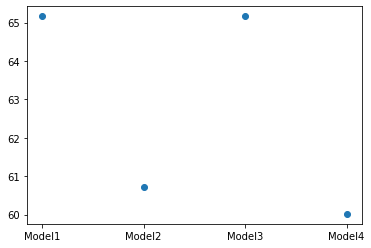

In [61]:
model_names = ["Model1","Model2","Model3","Model4"] 
# print(model_accuracy)
model_description = ["1 HL of 64 Neurons","2 HL of 64 Neurons","1 HL of 128 Neurons","2 HL of 128 Neurons" ] 
model_test_accuracies = []
model_test_loss = []


i = 0
while(i < len(model_accuracy)):
    model_test_accuracies.append(model_accuracy[i])
    model_test_loss.append(model_loss[i])
    i += 3    



for name, des,value, loss in zip(model_names, model_description, model_test_accuracies, model_test_loss):
    print(name, "with", des, "has testing accurracy of:", "{:.2f}".format(value.item()),"%", "and loss:", "{:.2f}".format(loss.item()))
    
plt.scatter(model_names, model_test_accuracies)
plt.show()

With increase in number of hidden layers, we see more time taken in training however there is no significant increase in accuracy in fact the accuracy has decreased and loss has increased. The increase in neurons does not seem to have any particular effect in this problem.